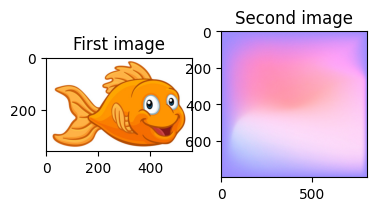

Block size:(2,2), Time processing on GPU: 0.16482853889465332s


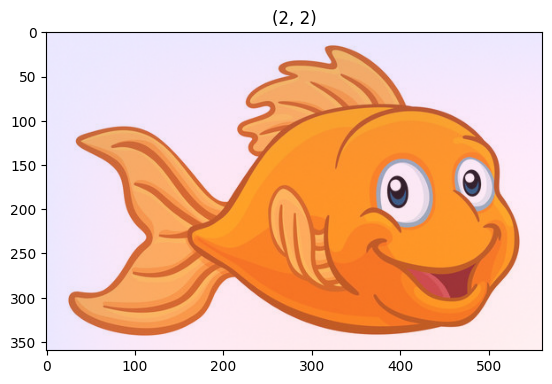

Block size:(4,4), Time processing on GPU: 0.00038814544677734375s


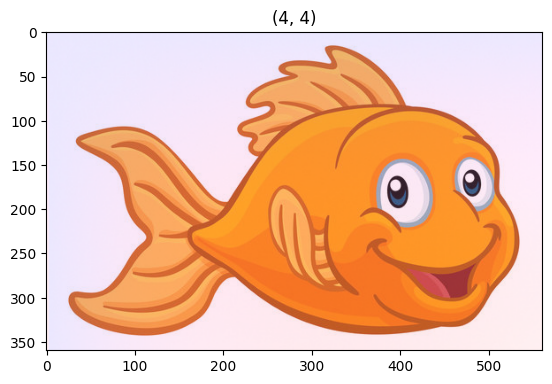

Block size:(8,8), Time processing on GPU: 0.0002799034118652344s


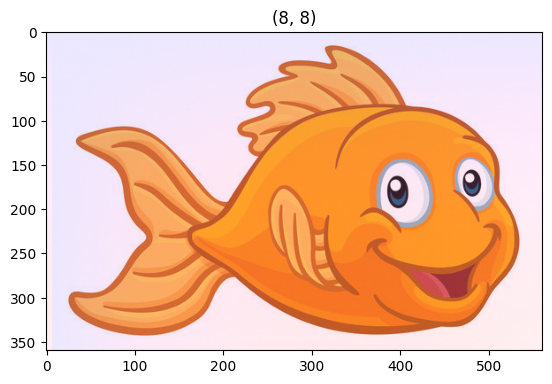

Block size:(16,16), Time processing on GPU: 0.00036215782165527344s


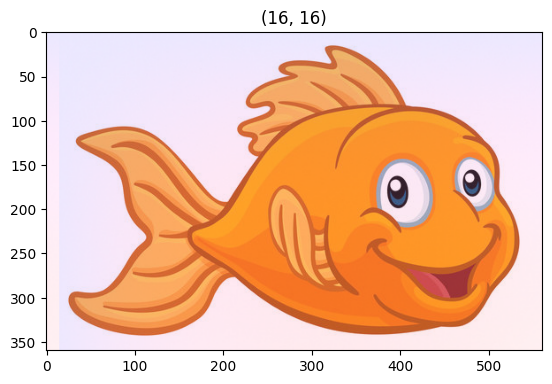

Block size:(32,32), Time processing on GPU: 0.00032329559326171875s


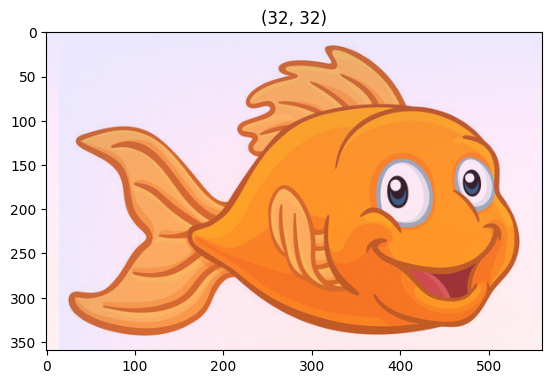

Block size:(32,22), Time processing on GPU: 0.0003104209899902344s


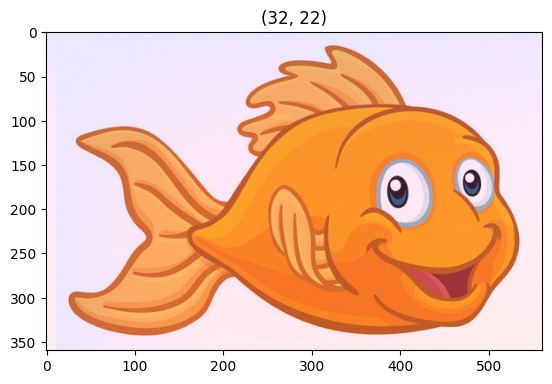

In [2]:
import numba
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import jit
from matplotlib.image import imread
import time

# Load images
first_image_path = 'labwork6c_first_image.jpg'
second_image_path = 'labwork6c_second_image.jpg'
first_image = imread(first_image_path)
second_image = imread(second_image_path)
plt.subplot(131), plt.imshow(first_image), plt.title('First image')
plt.subplot(132), plt.imshow(second_image), plt.title('Second image')

# Get the image dimensions
image_height = first_image.shape[0]
image_width = first_image.shape[1]

# Blending using GPU with 2D blocks
@cuda.jit
def blending_gpu(first_src, second_src, dst, c):
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    dst[x, y, 0] = first_src[x, y, 0] * c + (1 - c) * second_src[x, y, 0]
    dst[x, y, 1] = first_src[x, y, 1] * c + (1 - c) * second_src[x, y, 1]
    dst[x, y, 2] = first_src[x, y, 2] * c + (1 - c) * second_src[x, y, 2]

# Implement with GPU
blockSizes = [(2,2),(4,4),(8, 8),(16, 16),(32,32),(32,22)]
times_gpu = []
c = 0.8
plt.show()

# Implement blending
for block_size in blockSizes:
  first_devSrc = cuda.to_device(first_image)
  second_devSrc = cuda.to_device(second_image)

  devDst = cuda.device_array((image_height, image_width, 3), np.uint8)

  grid_size_x = (image_height + block_size[0] - 1) // block_size[0]
  grid_size_y = (image_width + block_size[1] - 1) // block_size[1]
  start_time_gpu = time.time()
  blending_gpu[(grid_size_x, grid_size_y), block_size](first_devSrc, second_devSrc, devDst, c)
  time_gpu = time.time() - start_time_gpu
  times_gpu.append(time_gpu)
  print(f"Block size:({block_size[0]},{block_size[1]}), Time processing on GPU: {time_gpu}s")

  hostDst = devDst.copy_to_host()
  blending_gpu_image = np.array(hostDst)
  plt.imsave(f'labwork6c-blending_({block_size[0]},{block_size[1]}).jpg', blending_gpu_image, cmap='gray')

  plt.title(block_size)
  plt.imshow(blending_gpu_image)
  plt.show()